In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import xgboost as xgb


from importlib import reload
import modules.markush as md # custom module
reload(md) # Automatically reload changes made to custom module
plt.rcParams['figure.figsize'] = (10, 5)

# Function Definitions

In [17]:
def preprocess_image(img):
    # Blur images very slightly to reduce effect of noise
    #img = cv2.blur(img, (3,3))

    return img

In [18]:
# A function for calculating features from a query image and matching it to a many template images
def orb_and_match_multiple(query_image, orb, matcher, templates, threshold=0.80):
    # We will have a list of matches, equal to the amount of template we will match against
    match_features = {}

    # Calculate keypoints and descriptor for the image we are querying.
    query_keypoints, query_descriptor = orb.detectAndCompute(query_image, None)

    for i in range(templates.shape[2]):
        # Get patch i from the templates and compute
        template_keypoints, template_descriptor = orb.detectAndCompute(templates[:,:,i], None)

        # Calculate matches, k is set to 2 to use Lowe's ratio test
        matches = matcher.knnMatch(query_descriptor, template_descriptor, k=2)

        # Ratio test as per Lowe's paper, filter out good matches
        distances = []
        match_count = 0
        for index in range(len(matches)):
            if len(matches[index]) == 2: # If there are two nearest neighbours
                m, n = matches[index]
                if m.distance < threshold * n.distance:  # 0.8 is threshold of ratio testing
                    distances.append(m.distance)        # We sum the distance of the best matches (m), if they are less than threshold * n.distance
                    match_count += 1       # Keep track of the amount of matches for a given template

        sorted_distances = sorted(distances)
        sorted_distances.extend([np.nan, np.nan, np.nan, np.nan, np.nan]) # Append 5 NaNs in case there are less than 5 matches
        match_features[f'temp{i}_match0'] = sorted_distances[0] # Distance of best match
        match_features[f'temp{i}_match1'] = sorted_distances[1] # Distance of second best match...
        match_features[f'temp{i}_match2'] = sorted_distances[2]
        match_features[f'temp{i}_match3'] = sorted_distances[3]
        match_features[f'temp{i}_match4'] = sorted_distances[4]
        match_features[f'temp{i}_nr_matches'] = match_count

        

    return match_features

In [19]:
# Function that converts a dataset with Markush images into a dataframe with features extracted from ORB
def create_feature_set(dataset, orb, matcher, templates):
    feature_set = []

    # For each image calculate the amount of matches and create a dataframe
    for i in range(len(dataset)):
        matches = orb_and_match_multiple(dataset[i]['image'], orb, matcher, templates)

        # We add the label to the matches dictionary, together they form the columns of our dataframe
        matches.update({'label': dataset[i]['label']})
        feature_set.append(matches) 
    return pd.DataFrame(feature_set)
    

# Loading Data


In [20]:
MD = md.MarkushDataset.from_dir('./data/training')
train_set, test_set = random_split(MD, [0.8, 0.2])

# Testing

In [21]:
# Create ORB object
orb = cv2.ORB_create(nfeatures=2000)

# Create a Brute Force Matcher object.
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = False)

# Create Dataset


In [22]:
# Get random set of patches to use as templates for ORB
templates = MD.random_markush_patches(10, give_context=False)

# Create a train set dataframe with the features that we will train our classifier on
train_set_features = create_feature_set(train_set, orb, matcher, templates)

# Create a test set for testing on
test_set_features = create_feature_set(test_set, orb, matcher, templates)

In [23]:
# Max score possible by simply guessing most common label:

max(len(MD.data[MD.data['label'] == 1]), len(MD.data[MD.data['label'] == 1]))/len(MD)

0.6029411764705882

In [24]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.01, eval_metric='logloss')


# Train the model on the training data
xgb_model.fit(train_set_features.drop(columns='label'), train_set_features['label'])

# Make predictions on the test data
y_pred = xgb_model.predict(test_set_features.drop(columns='label'))

# Evaluate the model
print("Accuracy:", accuracy_score(test_set_features['label'], y_pred))

Accuracy: 0.6296296296296297


In [25]:
scores = precision_recall_fscore_support(test_set_features['label'], y_pred, labels=xgb_model.classes_)

print(f"Precision - label 0: {scores[0][0]} - label 1: {scores[0][1]}")
print(f"Recall- label 0: {scores[1][0]} - label 1: {scores[1][1]}")
print(f"f score - label 0: {scores[2][0]} - label 1: {scores[2][1]}")
print(f"Support - label 0: {scores[3][0]} - label 1: {scores[3][1]}")

Precision - label 0: 0.5909090909090909 - label 1: 0.65625
Recall- label 0: 0.5416666666666666 - label 1: 0.7
f score - label 0: 0.5652173913043478 - label 1: 0.6774193548387096
Support - label 0: 24 - label 1: 30


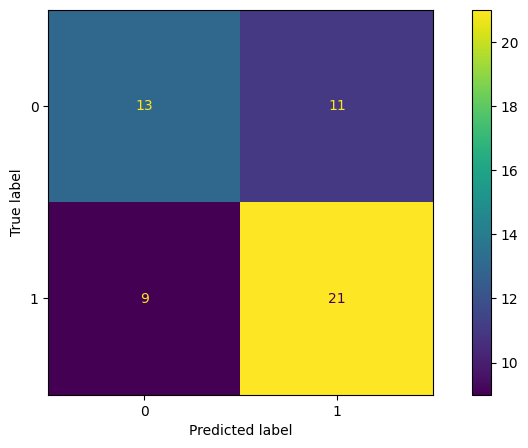

In [26]:
cm = confusion_matrix(test_set_features['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot()
plt.show()

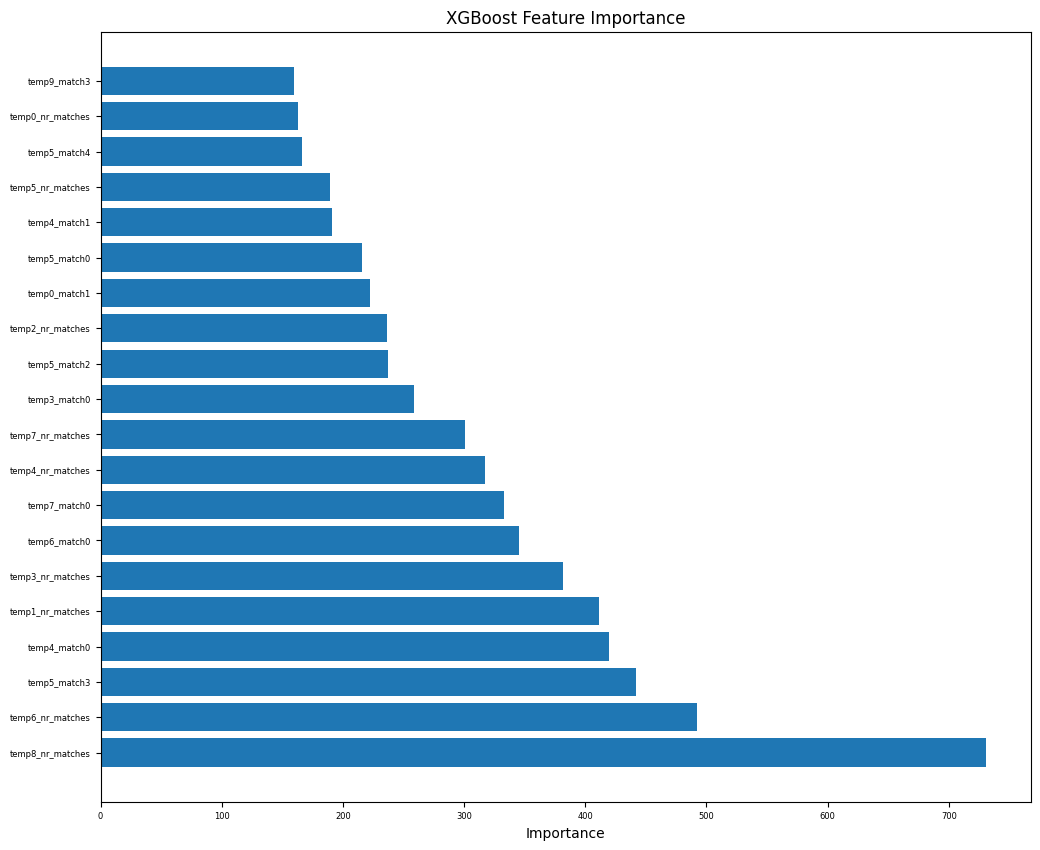

In [27]:
# Get feature importance data from xgb_model
importance_data = xgb_model.get_booster().get_score(importance_type='weight')

# Convert importance_data to a pandas dataframe
importance_df = pd.DataFrame({'feature': list(importance_data.keys()), 'importance': list(importance_data.values())})

# Sort importance_df by importance in descending order
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12,10))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.tick_params(axis='both', which='major', labelsize=6)
plt.show()


Template: #6


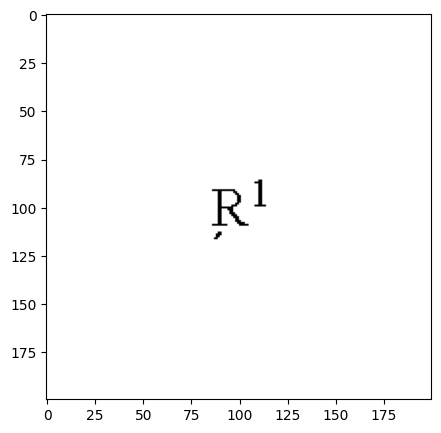

In [28]:
nr = 6
plt.imshow(templates[:,:,nr], cmap="gray")
print(f"Template: #{nr}")


# Visualisation

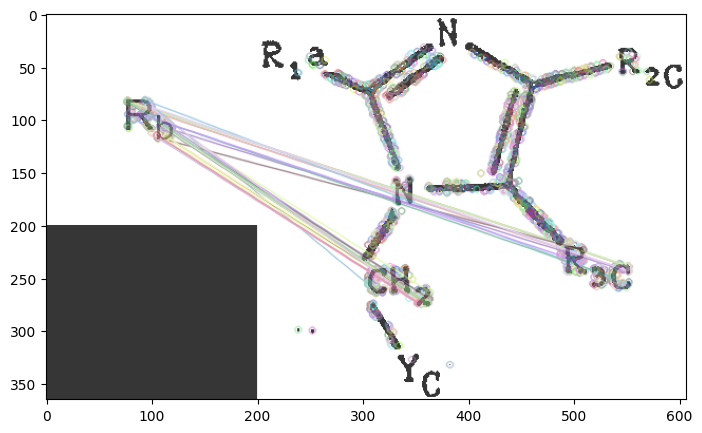

Matches:137, filtered: 16


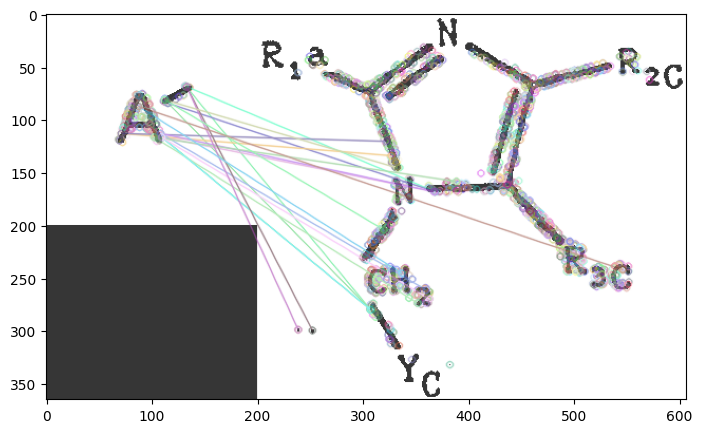

Matches:140, filtered: 10


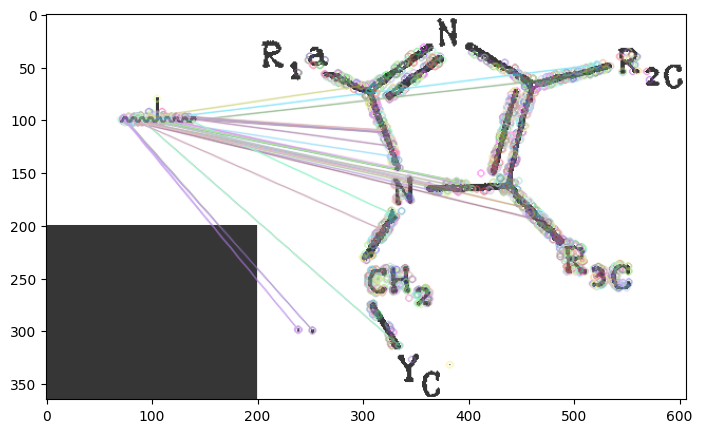

Matches:105, filtered: 17


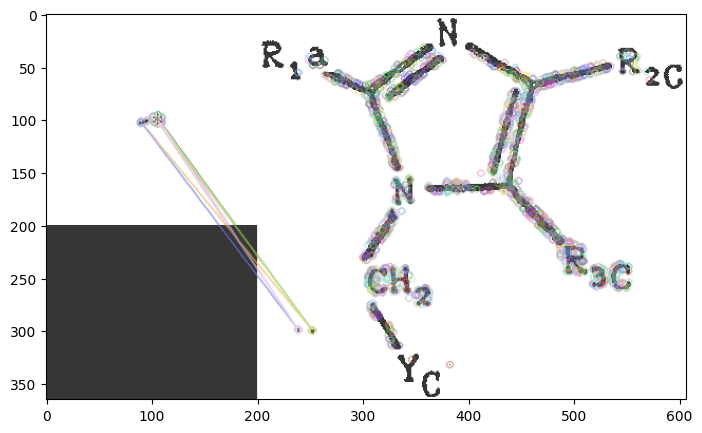

Matches:24, filtered: 6


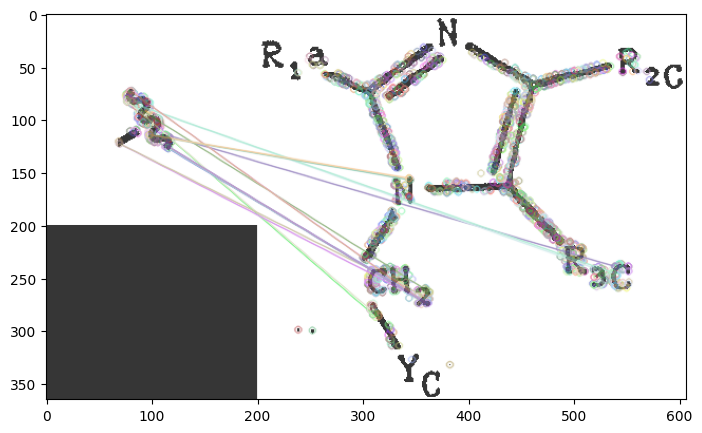

Matches:150, filtered: 9


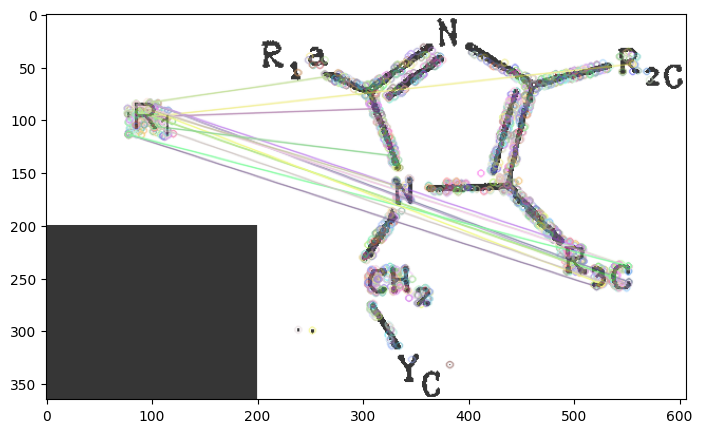

Matches:152, filtered: 8


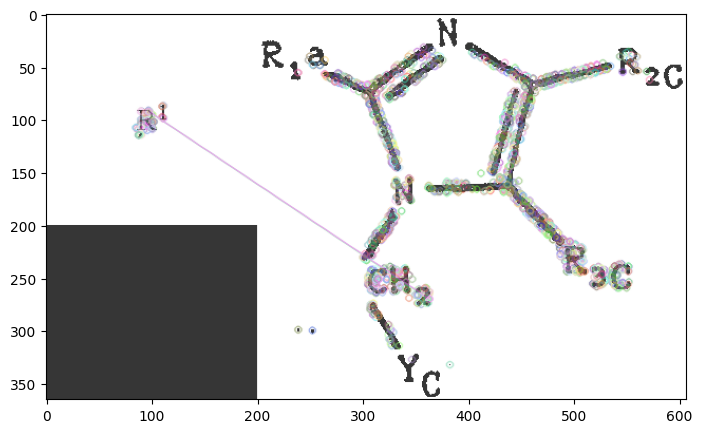

Matches:65, filtered: 1


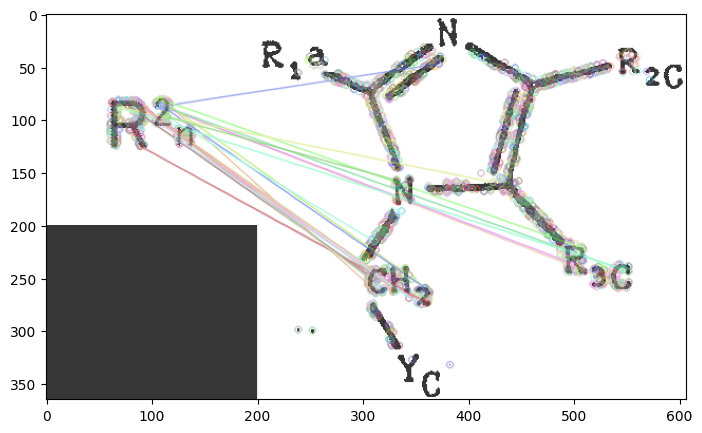

Matches:231, filtered: 13


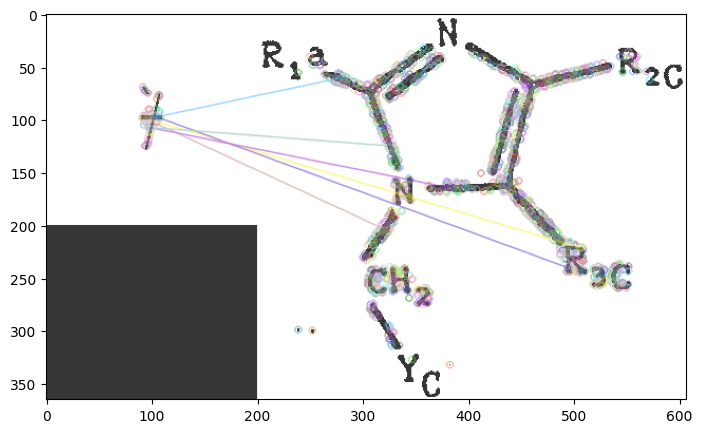

Matches:54, filtered: 3


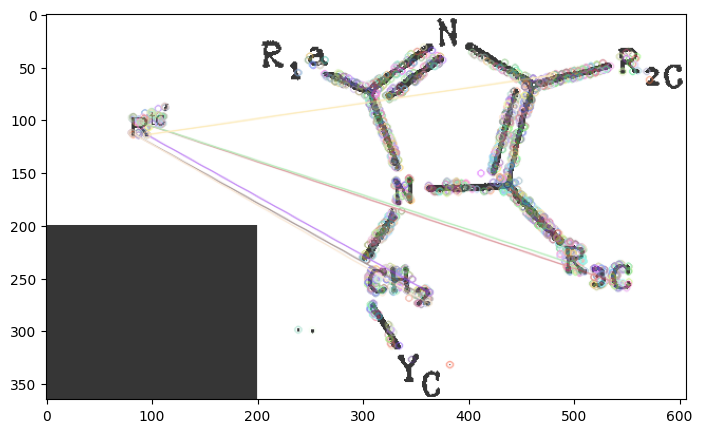

Matches:69, filtered: 3


In [29]:
threshold=0.80

query_image = MD[3]

# Create a Brute Force Matcher object.
#bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = False)

# Calculate keypoints and descriptor for the image we are querying.
query_keypoints, query_descriptor = orb.detectAndCompute(query_image['image'], None)

for i in range(templates.shape[2]):
    # Get patch i from the templates and compute
    template_keypoints, template_descriptor = orb.detectAndCompute(templates[:,:,i], None)

    # Calculate matches, k is set to 2 to use Lowe's ratio test
    matches = matcher.knnMatch(template_descriptor, query_descriptor, k=2)

    # Ratio test as per Lowe's paper, filter out good matches
    filtered_matches = []
    for index in range(len(matches)):
        if len(matches[index]) == 2:
            m, n = matches[index]
            if m.distance < threshold * n.distance:  # 0.8 is threshold of ratio testing
                filtered_matches.append(matches[index])


    
    result = cv2.drawMatchesKnn(templates[:,:,i], template_keypoints, query_image['image'], query_keypoints, filtered_matches, query_image['image'])
    result_no_matches = cv2.drawMatchesKnn(templates[:,:,i], template_keypoints, query_image['image'], 
                                       query_keypoints, filtered_matches, query_image['image'], matchesMask=[[0, 0] for i in range(len(filtered_matches))], flags=2)
    plt.imshow(result, alpha=0.7)
    plt.imshow(result_no_matches, alpha=0.3)
    plt.show()
    print(f"Matches:{len(matches)}, filtered: {len(filtered_matches)}")



In [31]:
for i in range(templates.shape[2]):
    # Get patch i from the templates and compute
    template_keypoints, template_descriptor = orb.detectAndCompute(templates[:,:,i], None)
    for kp in template_keypoints:
        if kp.pt[0] < 50:
            print(kp.pt)
            plt.imshow(templates[:,:,i])
            plt.show()